In [1]:
# Install packages
!pip install -q keras-eval stored matplotlib plotly

In [2]:
%matplotlib inline
import os
import numpy as np
# Import keras-eval
from keras_eval.eval import Evaluator
# Plot Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
import matplotlib
# Set GPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Plotly 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/albert/.venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import stored
# Download Test Dataset
stored.sync('https://storage.googleapis.com/sample-datasets/cats-vs-dogs/valid.zip', 'data/valid')

## Evaluator

Easy predictions and evaluations for a single model or an ensemble of many models.

You can add a model directly in the constructor, specifying the `model_path`, you will need to have its `model_spec.json` in the same folder too: 

The image preprocessing arguments are contained in `model_spec.json`. You can change the target_size to evaluate different image sizes. 

In [4]:
model_path = 'tmp/fixtures/models/ensemble/mobilenet_1/catdog-mobilenet.hdf5'

In [5]:
evaluator = Evaluator(
        data_dir=None,
        concept_dictionary_path=None,
        custom_objects=None,
        concepts=None,
        ensemble_models_dir=None,
        model_path=model_path,
        loss_function='categorical_crossentropy',
        metrics=['accuracy'],
        batch_size=32,
        verbose=0)

If you forgot to add it, or want to add more, you can do it with this function: 

In [6]:
evaluator.add_model(model_path = 'tmp/fixtures/models/ensemble/mobilenet_2/catdog-mobilenet.hdf5')

In [7]:
print('The number of models to evaluate are: ', len(evaluator.models))

The number of models to evaluate are:  2


If you want to remove a model, you just have to specify its index. Let's remove the last added:

In [8]:
evaluator.remove_model(model_index=1)

In [9]:
print('The number of models to evaluate are: ', len(evaluator.models))

The number of models to evaluate are:  1


## Evaluation Functions

### Evaluate a set of images. 

Each sub-folder under `'data_dir/'` will be considered as a different class. E.g. `'data_dir/class_1/dog.jpg'` , `'data_dir/class_2/cat.jpg'`
If you are evaluating an ensemble of models, we currently allow for these probability combination modes: `'maximum'`, `'arithmetic'`, `'geometric'`, `'harmonic'`

**evaluate**

In [10]:
data_dir = 'data/valid/'
probs, labels = evaluator.evaluate(data_dir=data_dir, top_k=1, filter_indices=None, confusion_matrix=False, save_confusion_matrix_path=None)

Making predictions from model  0
Found 2000 images belonging to 2 classes.
Input image size:  [224, 224, 3]
63/63 [==============================] - 12s 194ms/step


In [11]:
# Print Results 
evaluator.show_results('average')

,id,accuracy,weighted_precision,sensitivity,precision,f1_score,number_of_samples,number_of_classes
0,catdog-mobilenet.hdf5,0.583,0.643,0.583,0.643,0.534,2000,2


In [12]:
# Print Results per each class
evaluator.show_results('individual')

,id,class,sensitivity,precision,f1_score,specificity,FDR,AUROC,TP,FP,FN,% of samples
0,catdog-mobilenet.hdf5,cats,0.907,0.550,0.685,0.259,0.450,1.0,907,741,93,50.0
1,catdog-mobilenet.hdf5,dogs,0.259,0.736,0.383,0.907,0.264,1.0,259,93,741,50.0


In [13]:
# Check Shapes
print(probs.shape) # [n_models, n_samples, n_classes]
print(labels.shape) # [n_samples, n_classes]

(1, 2000, 2)
(2000, 2)


In [14]:
# Save results for later use
evaluator.save_results(id='cats_vs_dogs', csv_path='test_results_average', mode='average', round_decimals=4, show_id=True)
evaluator.save_results(id='cats_vs_dogs', csv_path='test_results_class', mode='individual', round_decimals=4, show_id=True)

Also you can set the names for each class using a list of dictionaries as follows:

In [15]:
concepts = [{'label':'Cat', 'id': 'cats'},
           {'label':'Dog', 'id': 'dogs'}]

evaluator.set_concepts(concepts)

If you want to show a pretty **Confusion Matrix** set `confusion_matrix=True` and you can store it too by setting `save_confusion_matrix_path='name.png'`

Making predictions from model  0
Found 2000 images belonging to 2 classes.
Input image size:  [224, 224, 3]
63/63 [==============================] - 13s 201ms/step


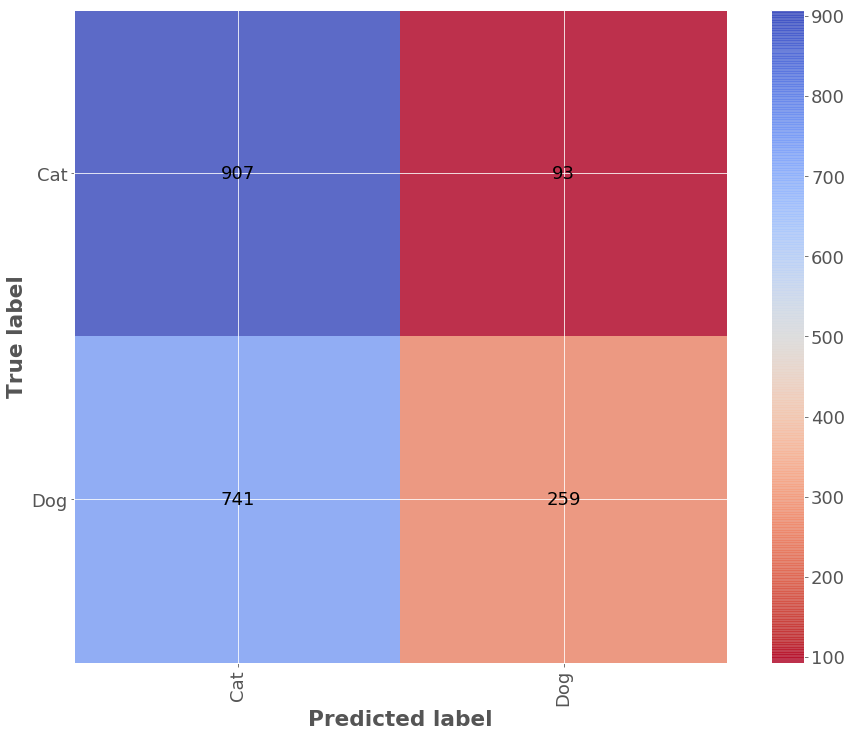

In [16]:
probs, labels = evaluator.evaluate(data_dir=data_dir, top_k=2, confusion_matrix=True, save_confusion_matrix_path='cm.png')

In [17]:
evaluator.show_results('average')

,id,accuracy_top_1,accuracy_top_2,weighted_precision,sensitivity,precision,f1_score,number_of_samples,number_of_classes
0,catdog-mobilenet.hdf5,0.583,1.0,0.643,0.583,0.643,0.534,2000,2


In [18]:
evaluator.show_results('individual')

,id,class,sensitivity_top_1,sensitivity_top_2,precision,f1_score,specificity,FDR,AUROC,TP,FP,FN,% of samples
0,catdog-mobilenet.hdf5,Cat,0.907,1.0,0.550,0.685,0.259,0.450,1.0,907,741,93,50.0
1,catdog-mobilenet.hdf5,Dog,0.259,1.0,0.736,0.383,0.907,0.264,1.0,259,93,741,50.0


* You can plot the **Receiver Operating Characteristic (ROC)** curve:

In [19]:
from keras_eval.visualizer import plot_ROC_curve

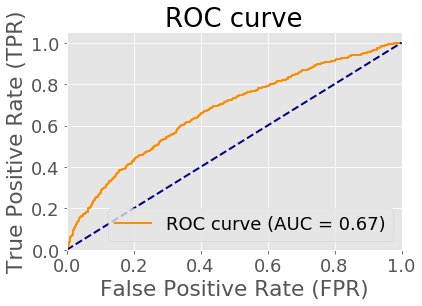

In [20]:
plot_ROC_curve(probs[0][:,1], labels[:,1])

* As well as the **Precision-Recall curve**:

In [21]:
from keras_eval.visualizer import plot_precision_recall_curve

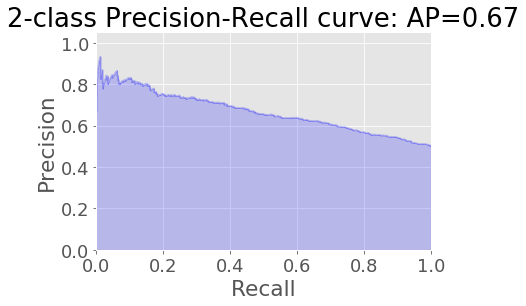

In [22]:
plot_precision_recall_curve(probs[0][:,1], labels[:,1])

These were the labels by default, but you can set custom names for your classes!

Plotting the sensitivity of each class and the global model accuracy: 

In [23]:
evaluator.plot_top_k_sensitivity_by_concept()

In [24]:
evaluator.plot_top_k_accuracy()

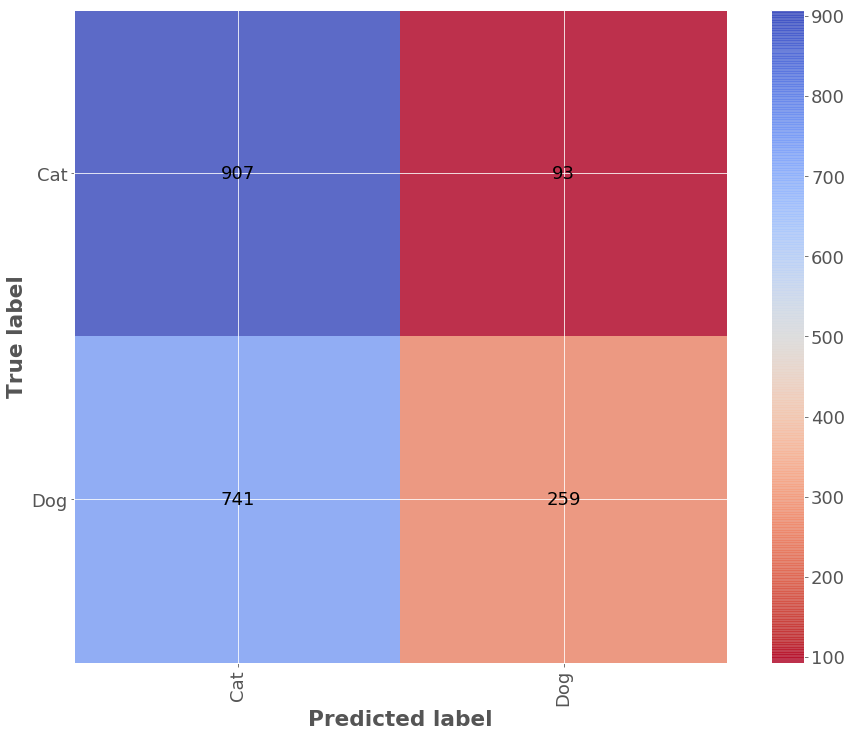

In [25]:
evaluator.plot_confusion_matrix(evaluator.results['average']['confusion_matrix'])

You can obtain the correct/erroneous images for every square of the confusion matrix and their probabilities

In [26]:
dict_images = evaluator.get_image_paths_by_prediction(probs[0], labels)

We'll print the images of dogs confused as cats

In [27]:
print(dict_images['Dog_Cat']['image_paths'])

['data/valid/dogs/dog.10001.jpg', 'data/valid/dogs/dog.10005.jpg', 'data/valid/dogs/dog.1001.jpg', 'data/valid/dogs/dog.10010.jpg', 'data/valid/dogs/dog.10018.jpg', 'data/valid/dogs/dog.10033.jpg', 'data/valid/dogs/dog.10038.jpg', 'data/valid/dogs/dog.10051.jpg', 'data/valid/dogs/dog.10063.jpg', 'data/valid/dogs/dog.1008.jpg', 'data/valid/dogs/dog.10098.jpg', 'data/valid/dogs/dog.10102.jpg', 'data/valid/dogs/dog.10103.jpg', 'data/valid/dogs/dog.10117.jpg', 'data/valid/dogs/dog.10124.jpg', 'data/valid/dogs/dog.10133.jpg', 'data/valid/dogs/dog.10139.jpg', 'data/valid/dogs/dog.1014.jpg', 'data/valid/dogs/dog.10141.jpg', 'data/valid/dogs/dog.1018.jpg', 'data/valid/dogs/dog.10204.jpg', 'data/valid/dogs/dog.10208.jpg', 'data/valid/dogs/dog.10222.jpg', 'data/valid/dogs/dog.10244.jpg', 'data/valid/dogs/dog.10251.jpg', 'data/valid/dogs/dog.10252.jpg', 'data/valid/dogs/dog.10255.jpg', 'data/valid/dogs/dog.10279.jpg', 'data/valid/dogs/dog.10282.jpg', 'data/valid/dogs/dog.10288.jpg', 'data/valid/d

In [28]:
print(dict_images['Dog_Cat']['probs'])

[array([0.77949595, 0.22050405], dtype=float32), array([0.8363643 , 0.16363567], dtype=float32), array([0.74517274, 0.2548272 ], dtype=float32), array([0.6102432 , 0.38975683], dtype=float32), array([0.9433235 , 0.05667654], dtype=float32), array([0.9875706 , 0.01242947], dtype=float32), array([0.9359975 , 0.06400245], dtype=float32), array([0.98053473, 0.01946523], dtype=float32), array([0.7796615 , 0.22033848], dtype=float32), array([0.81883186, 0.18116818], dtype=float32), array([0.9303254 , 0.06967469], dtype=float32), array([0.6625808 , 0.33741924], dtype=float32), array([0.91542155, 0.08457848], dtype=float32), array([0.5610122, 0.4389878], dtype=float32), array([0.8735846 , 0.12641531], dtype=float32), array([0.52943784, 0.4705622 ], dtype=float32), array([0.9721239 , 0.02787602], dtype=float32), array([0.8117085, 0.1882915], dtype=float32), array([0.7261173, 0.2738827], dtype=float32), array([0.79178005, 0.20821995], dtype=float32), array([0.8192645 , 0.18073553], dtype=float32

We can also plot them with:

/home/albert/.venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



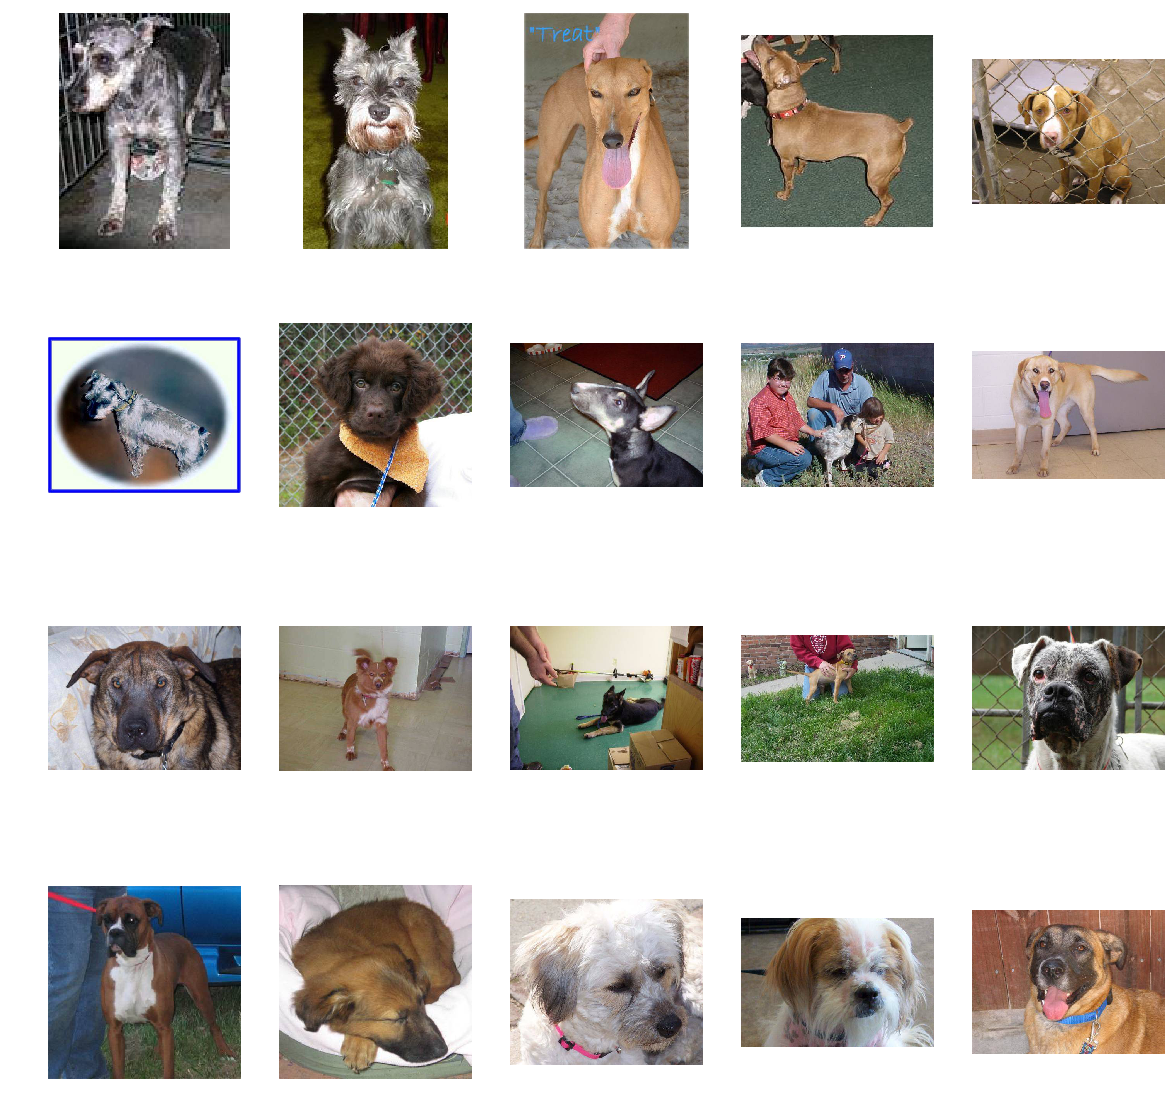

In [30]:
# We'll print the first 20
evaluator.plot_images(dict_images['Dog_Cat']['image_paths'], n_images=20)

### Confidence Classifier

You can observe how sure can you be that your classifier will be right when making predictions with certain probailities. Percentage of confidence values accepted are 0.9, 0.95, 0.98, 0.99 or equivalently 90, 95, 98, 99. They correspond to the normal distribution. Two modes, "accuracy" and "error" are supported. 

In [31]:
mean, lower, upper = evaluator.plot_confidence_interval('accuracy', confidence_value=0.95)

Returning correct predictions and errors for the top k:  [1]


### Errors when most confident

We can plot the errors for which the predicted probability was higher.

Returning correct predictions and errors for the top k:  [1]


/home/albert/.venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



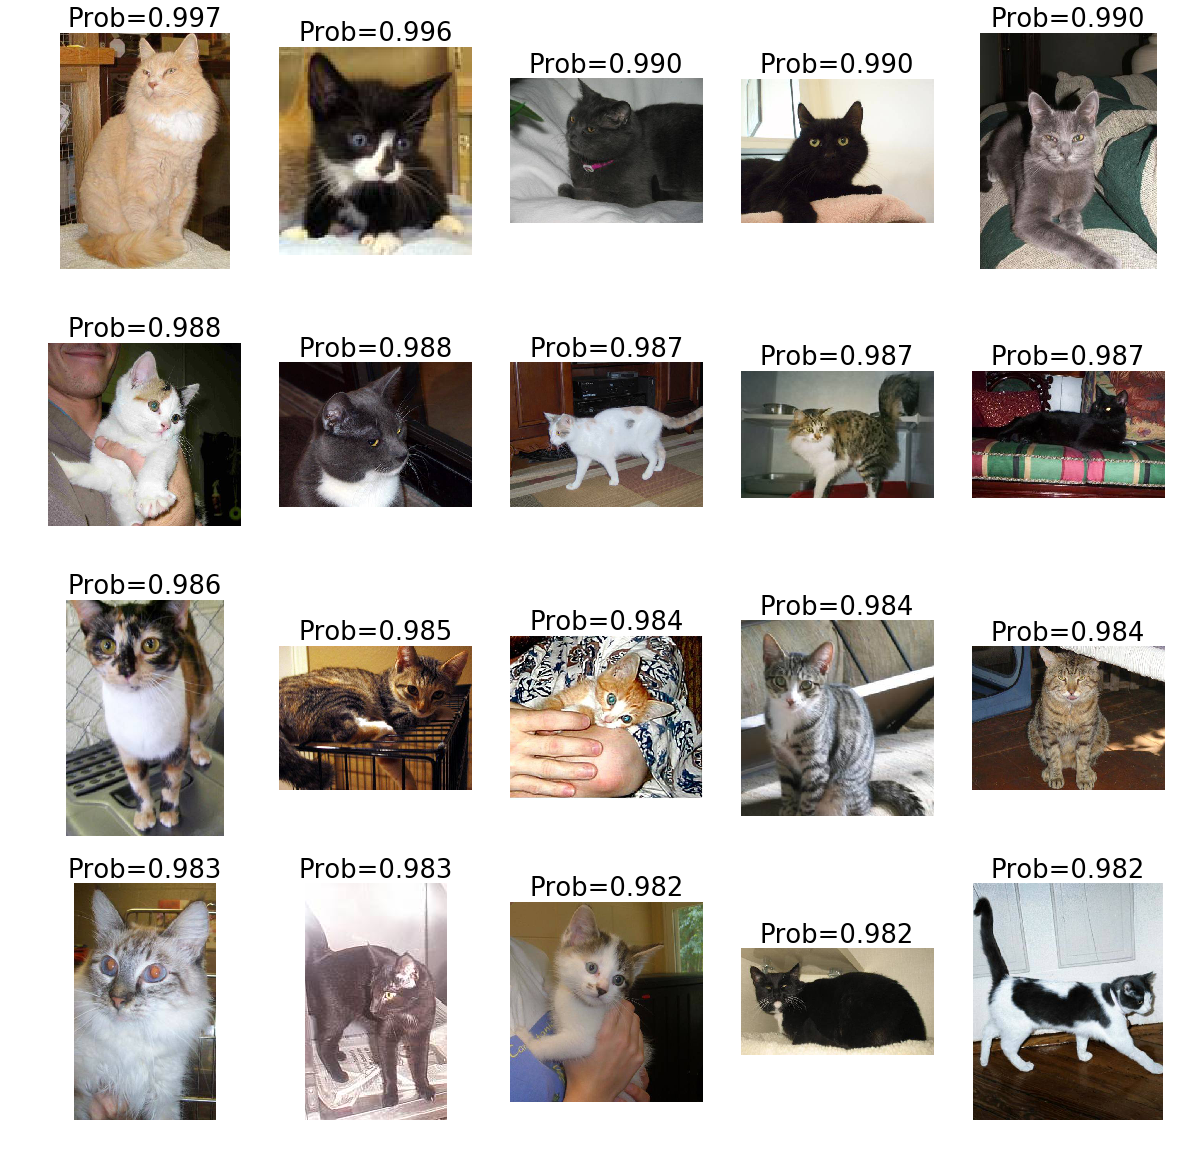

In [32]:
evaluator.plot_most_confident('errors', n_images=20)

### Histogram of Probabilities

Returning correct predictions and errors for the top k:  [1]


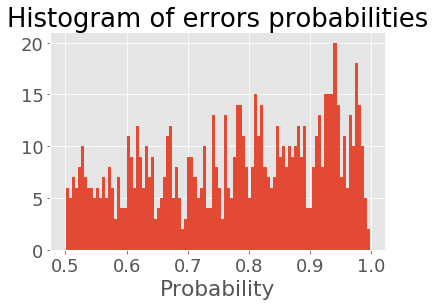

In [33]:
evaluator.plot_probability_histogram('errors')

Returning correct predictions and errors for the top k:  [1]


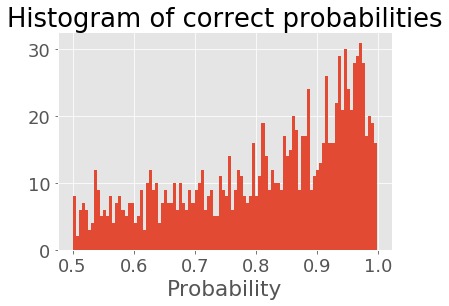

In [34]:
evaluator.plot_probability_histogram('correct')

### Uncertainty

In [35]:
uncertainty = evaluator.compute_uncertainty_distribution()

There are 2 classes 
Max uncertainty value is 1.000
The mean entropy or uncertainty per image is 0.629


### Effect of Probability Threshold

Effect on the number of correct predictions detected, error predictions removed when thresholding on probability. 
It is equivalent of only accepting prediction if the top-1 probability is > than the threshold:

In [36]:
# Threholds from 0 to 1, taking steps of 0.01
import numpy as np
threshold = np.arange(0, 1.01, 0.01)
correct_list, errors_list, n_correct, n_errors = evaluator.show_threshold_impact(probs, labels, type='probability')

Returning correct predictions and errors for the top k:  [1]


### Perform Data Augmentation at Test Time

Keras-eval includes the addition of data_augmentation as an argument to `evaluate()`. It is a dictionary consisting of 3 elements:
- 'scale_sizes': 'default' (4 similar scales to Google's paper) or a list of sizes. Each scaled image then
will be cropped into three square parts.
- 'transforms': list of transforms to apply to these crops in addition to not
applying any transform ('horizontal_flip', 'vertical_flip', 'rotate_90', 'rotate_180', 'rotate_270' are
supported now).
- 'crop_original': 'center_crop' mode allows to center crop the original image prior do the rest of transforms,
scalings + croppings.

For instance: `data_augmentation={'scale_sizes': 'default', 'transforms': ['horizontal_flip', 'rotate_180'],
'crop_original': 'center_crop'}`

Making predictions from model  0
Found 2000 images belonging to 2 classes.
Input image size:  [224, 224, 3]
Averaging probabilities of 72 different outputs at sizes: [356, 284] with transforms: ['none', 'horizontal_flip']
2000/2000 [==============================] - 0s 0us/step


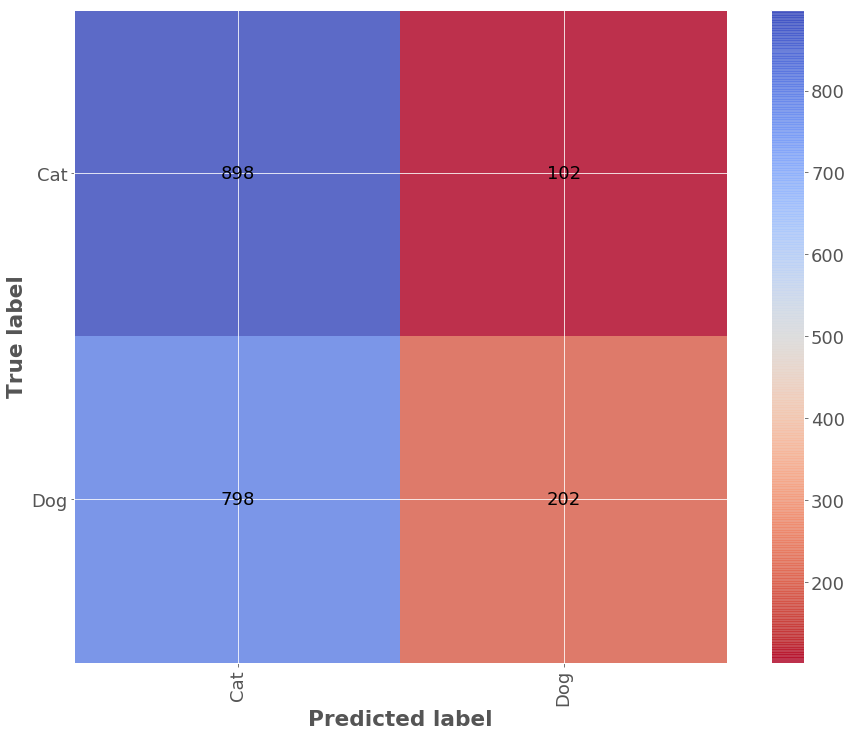

In [37]:
probs, labels = evaluator.evaluate(data_dir=data_dir, top_k=2, confusion_matrix=True, data_augmentation={'scale_sizes': [356, 284], 'transforms': ['horizontal_flip'], 'crop_original': 'center_crop'})

### Predict class probabilities of a set of images from a folder.

**predict**

In [38]:
folder_path = 'data/valid/cats/'
probs = evaluator.predict(folder_path)

Making predictions from model  0
1000/1000 [==============================] - 1s 1ms/step


You can access to the predicted image paths, they are contained in `evaluator.image_paths`

This is what the image looks like: 


/home/albert/.venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



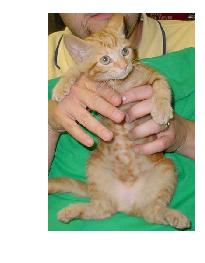

In [39]:
# We will plot the first image
image_0 = evaluator.image_paths[0]
plt.imshow(mpimg.imread(image_0))
plt.grid('off')
plt.axis('off')
print('This is what the image looks like: ')

In [40]:
print('These are the probabilities for the first image: ') # Probabilities of the first image predicted
for index, c in enumerate(concepts):
    print('Probability for ' + c['label'] + ' class is %.4f'%probs[0, 0, index])

These are the probabilities for the first image: 
Probability for Cat class is 0.8475
Probability for Dog class is 0.1525


### Predict class probabilities for a single image

**predict**

/home/albert/.venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



This is what the image looks like: 


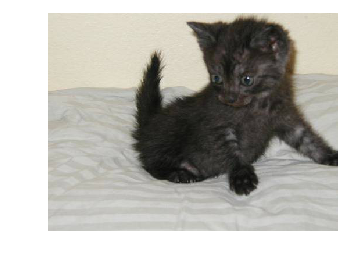

In [41]:
# We'll show the image we want to predict
image_path = 'data/valid/cats/cat.11878.jpg'
plt.imshow(mpimg.imread(image_path))
plt.grid('off')
plt.axis('off')
print('This is what the image looks like: ')

In [42]:
probs = evaluator.predict(image_path)

Making predictions from model  0
1/1 [==============================] - 0s 66ms/step


In [43]:
for index, c in enumerate(concepts):
    print('Probability for ' + c['label'] + ' class is %.4f'%probs[0, 0, index])

Probability for Cat class is 0.5827
Probability for Dog class is 0.4173


### Using an ensemble of multiple models

We allow using evaluating multiple models at once. The models should have been trained on the same classes.
You can add the models separately, or all together, using the parameter `ensemble_models_dir`, every model should be in a separate folder. 
The parameter `combination_mode` is used to set the way of combining probabilities before evaluating. There are 4 modes available: `'arithmetic'`, `'maximum'`, `'geometric'` and `'harmonic'`. 

In [44]:
evaluator = Evaluator(
        id='cats-vs-dogs',
        data_dir='data/valid/',
        concepts=[{'label': 'Cat', 'id': 'cat'}, {'label': 'Dog', 'id': 'dog'}],
        ensemble_models_dir='tmp/fixtures/models/ensemble/',
        combination_mode='arithmetic',
        model_path=None,
        batch_size=32,
        verbose=0)

Loading model  catdog-mobilenet.hdf5
Loading model  catdog-mobilenet.hdf5
Models loaded:  2


In [45]:
probs, labels = evaluator.evaluate()

Making predictions from model  0
Found 2000 images belonging to 2 classes.
Input image size:  [224, 224, 3]
63/63 [==============================] - 12s 195ms/step
Making predictions from model  1
Found 2000 images belonging to 2 classes.
Input image size:  [224, 224, 3]
63/63 [==============================] - 12s 196ms/step


By default we return the probabilities of both models separately. But you can have the combined probabilities by accessing `evaluator.combined_probabilities`. 

In [46]:
# All models predictions
print(probs.shape)
# Combined models predictions
print(evaluator.combined_probabilities.shape)

(2, 2000, 2)
(2000, 2)


### Training on granular classes and testing coarse classes 

We allow you to train on more granular classes like dog, cat, lions and tigers and evalauate on more granular classes such as domestic animals (combination of dogs and cats) and wild animals (combination of lions and tigers). To do this you would have to provide a `.json` file as explained in the ReadMe. The location of file should be given as the argument `concept_dictionary_path` when the evlauator object is created as seen below.

#### Evalution on Granular Classes 

In [47]:
import stored
stored.sync('https://storage.googleapis.com/triage-lab/datasets/animals_granular_test.zip', 'data/test')

In [48]:
model_path = 'tmp/fixtures/models/single/animals-mobilenet.hdf5'

In [49]:
data_dir = 'data/test/animals_granular_test/'

In [50]:
evaluator_granular = Evaluator(
        data_dir=data_dir,
        concept_dictionary_path=None,
        custom_objects=None,
        concepts=None,
        ensemble_models_dir=None,
        model_path=model_path,
        loss_function='categorical_crossentropy',
        metrics=['accuracy'],
        batch_size=32,
        verbose=0)

Making predictions from model  0
Found 15 images belonging to 5 classes.
Input image size:  [299, 299, 3]
1/1 [==============================] - 2s 2s/step


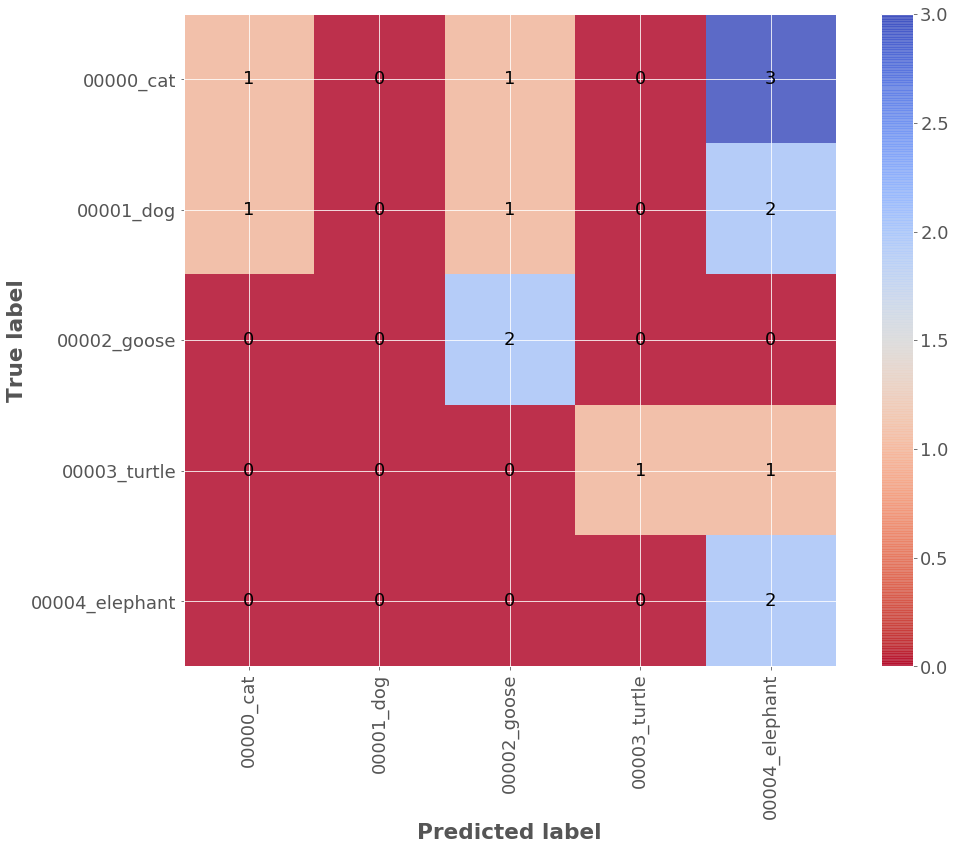

In [51]:
probs, labels = evaluator_granular.evaluate(data_dir=data_dir,top_k=1, filter_indices=None, confusion_matrix=True, save_confusion_matrix_path=None)

In [52]:
evaluator_granular.show_results('average')

,id,accuracy,weighted_precision,sensitivity,precision,f1_score,number_of_samples,number_of_classes
0,animals-mobilenet.hdf5,0.4,0.4,0.54,0.45,0.326,15,5


In [53]:
evaluator_granular.show_results('individual')

,id,class,sensitivity,precision,f1_score,TP,FP,FN,% of samples
0,animals-mobilenet.hdf5,00000_cat,0.2,0.50,0.286,1,1,4,33.33
1,animals-mobilenet.hdf5,00001_dog,0.0,NaN,NaN,0,0,4,26.67
2,animals-mobilenet.hdf5,00002_goose,1.0,0.50,0.667,2,2,0,13.33
3,animals-mobilenet.hdf5,00003_turtle,0.5,1.00,0.667,1,0,1,13.33
4,animals-mobilenet.hdf5,00004_elephant,1.0,0.25,0.400,2,6,0,13.33


#### Evaluation on Coarse classes  

In [54]:
data_dir = 'tests/files/animals/test/'

In [55]:
evaluator_coarse = Evaluator(
        data_dir=data_dir,
        concept_dictionary_path='./tests/files/animals/dictionary.json',
        custom_objects=None,
        concepts=None,
        ensemble_models_dir=None,
        model_path=model_path,
        loss_function='categorical_crossentropy',
        metrics=['accuracy'],
        batch_size=32,
        verbose=0
        )

Making predictions from model  0
Found 15 images belonging to 3 classes.
Input image size:  [299, 299, 3]
1/1 [==============================] - 2s 2s/step


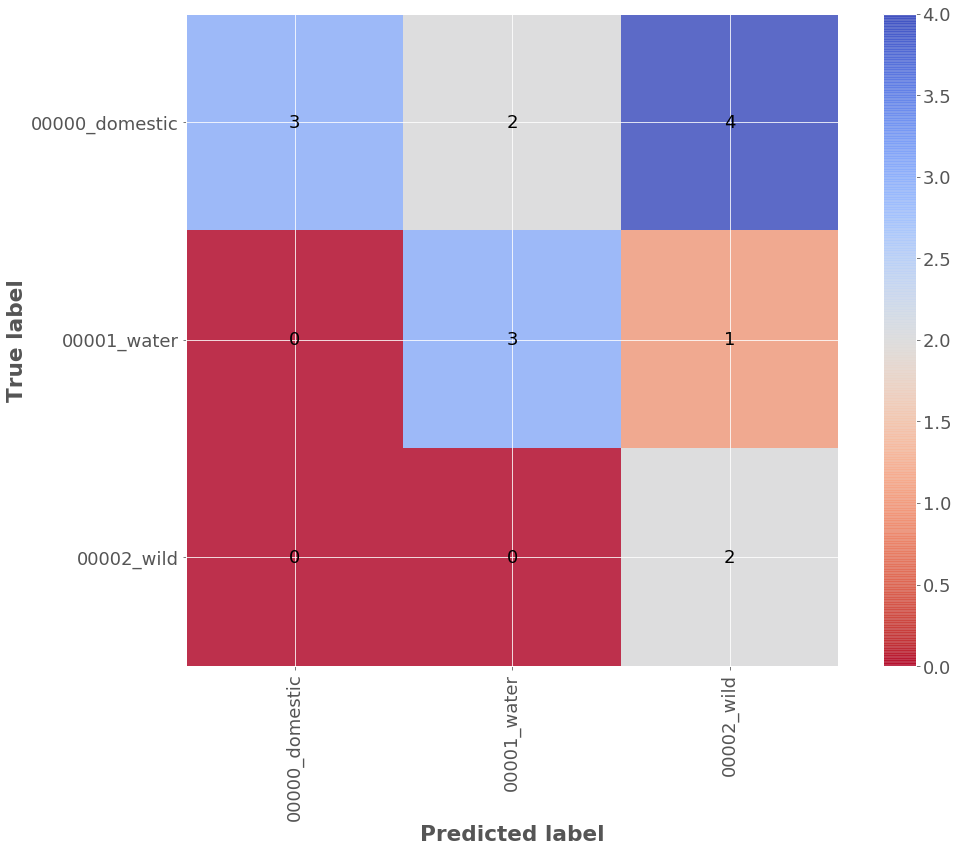

In [56]:
probs, labels = evaluator_coarse.evaluate(data_dir=data_dir,top_k=1, filter_indices=None, confusion_matrix=True, save_confusion_matrix_path=None)

The model was trained on 5 classes but is being evaluated on 3 classes. So we combine the probabilities to 3 classes as seen by the `.shape` method

In [57]:
evaluator_coarse.show_results('average')

,id,accuracy,weighted_precision,sensitivity,precision,f1_score,number_of_samples,number_of_classes
0,animals-mobilenet.hdf5,0.533,0.798,0.694,0.629,0.537,15,3


In [58]:
evaluator_coarse.show_results('individual')

,id,class,sensitivity,precision,f1_score,TP,FP,FN,% of samples
0,animals-mobilenet.hdf5,00000_domestic,0.333,1.000,0.500,3,0,6,60.00
1,animals-mobilenet.hdf5,00001_water,0.750,0.600,0.667,3,2,1,26.67
2,animals-mobilenet.hdf5,00002_wild,1.000,0.286,0.444,2,5,0,13.33
